Random Model Parameters: {'W': 4.479977571033436e-06, 'L': 8.854215445037355e-06, 'KP': 0.00013218255806681997, 'VTO': 0.5032554094553539, 'LAMBDA': 0.02, 'PHI': 0.4}


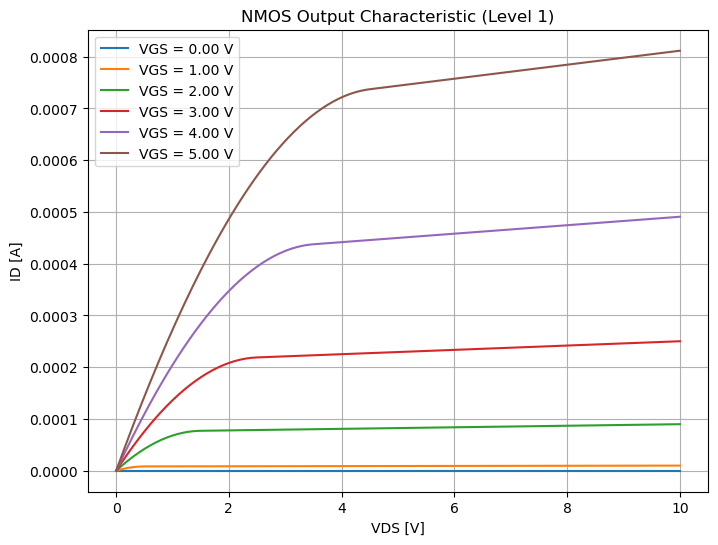

Data saved to 'nmos_output_characteristics.csv'.


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import csv

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import u_V
from random import uniform

###############################################################################
# 1) Generate a random Level 1 NMOS model parameter dictionary
###############################################################################
FIXED_LAMBDA = 0.02  # Typical channel-length modulation parameter
FIXED_PHI = 0.4  # More realistic Fermi potential

def generate_random_level1_model():
    return {
        'W'     : uniform(1e-6, 50e-6),  # Channel width (1µm - 50µm)
        'L'     : uniform(2e-6, 10e-6),  # Channel length (2µm - 10µm)
        'KP'    : uniform(50e-6, 500e-6),  # Transconductance parameter (50µA/V² - 500µA/V²)
        'VTO'   : uniform(0.3, 1.2),  # Threshold voltage (0.3V - 1.2V)
        'LAMBDA': FIXED_LAMBDA,  # Fixed channel-length modulation
        'PHI'   : FIXED_PHI  # More realistic Fermi potential (0.4V instead of 0.7V)
    }
###############################################################################
# 2) Function to build the NMOS circuit
###############################################################################
def build_nmos_circuit(model_params):
    """
    Build a simple NMOS test bench:

        Drain supply = V('dd', 'drain', ground, 0V) (we'll sweep this)
        Gate voltage = V('in', 'gate', ground, ???) (fixed in each sub-sweep)
        Source to ground
        Bulk shorted to source
    """
    circuit = Circuit('Random_Level1_NMOS_Test')

    circuit.model('NMOSMOD', 'NMOS',
                  LEVEL=1,
                  KP=model_params['KP'],
                  VTO=model_params['VTO'],
                  LAMBDA=model_params['LAMBDA'],
                  PHI=model_params['PHI'],
                  W=model_params['W'],
                  L=model_params['L'])

    # Transistor M1
    circuit.MOSFET('M1', 'drain', 'gate', 'source', 'source', model='NMOSMOD')

    # Drain supply (we'll sweep this from 0 to 5 V)
    circuit.V('dd', 'drain', circuit.gnd, 0@u_V)

    # Source tied to ground
    circuit.R('SRC', 'source', circuit.gnd, 0)

    # Gate voltage source (fixed in each iteration of the sweep)
    circuit.V('in', 'gate', circuit.gnd, 0@u_V)

    return circuit

###############################################################################
# 3) Function to get the output characteristic
###############################################################################
def get_output_characteristic(model_params, 
                             gate_voltages=[1.0, 2.0, 3.0, 4.0], 
                             vds_start=0.0, 
                             vds_stop=5.0, 
                             vds_step=0.1):
    """
    Build a circuit from model_params, then for each gate voltage in 
    `gate_voltages`, set Vgs = that value and sweep the drain supply 
    from vds_start to vds_stop in increments of vds_step. 

    Returns a dictionary:

        results = {
          VGS_value: {
             'vds': numpy_array_of_VDS_points,
             'id':  numpy_array_of_ID_points
          },
          ...
        }
    """
    circuit = build_nmos_circuit(model_params)
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)

    results = {}

    for vgs in gate_voltages:
        # Set gate voltage
        circuit['Vin'].dc_value = vgs

        # Sweep drain voltage
        analysis = simulator.dc(Vdd=slice(vds_start, vds_stop, vds_step))

        vds_array = np.array(analysis.nodes['drain'])
        i_vdd = np.array(analysis.branches['vdd'])
        # Flip sign to get ID positive (SPICE gives current into the supply)
        id_array = -i_vdd

        results[vgs] = {
            'vds': vds_array,
            'id' : id_array
        }

    return results

###############################################################################
# 4) Helper to plot the output characteristic
###############################################################################
def plot_output_characteristic(results):
    plt.figure(figsize=(8, 6))

    for vgs, data in results.items():
        vds_array = data['vds']
        id_array  = data['id']
        plt.plot(vds_array, id_array, label=f'VGS = {vgs:.2f} V')

    plt.title('NMOS Output Characteristic (Level 1)')
    plt.xlabel('VDS [V]')
    plt.ylabel('ID [A]')
    plt.grid(True)
    plt.legend()
    plt.show()

###############################################################################
# 5) Save results to a CSV
###############################################################################
def save_results_to_csv(results, filename='output_characteristics.csv'):
    """
    Saves data to a CSV file with columns: VGS, VDS, ID
    Each VGS set is appended below the previous set.
    """
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # Write a header row
        writer.writerow(['VGS', 'VDS', 'ID'])

        # For each gate voltage, write rows for each point of VDS and ID
        for vgs, data in results.items():
            vds_array = data['vds']
            id_array  = data['id']
            for vds_val, id_val in zip(vds_array, id_array):
                writer.writerow([vgs, vds_val, id_val])

    print(f"Data saved to '{filename}'.")

###############################################################################
# 6) Main routine
###############################################################################
def main():
    model_params = generate_random_level1_model()
    print("Random Model Parameters:", model_params)

    more_gate_voltages = np.arange(0.0,5.1, 1)

    # Sweep for gate voltages from 1 to 5V
    results = get_output_characteristic(
        model_params,
        gate_voltages=more_gate_voltages,
        vds_start=0.0,
        vds_stop=10.0,
        vds_step=0.05
    )

    # Plot the family of curves
    plot_output_characteristic(results)

    # Save the data into a CSV file
    save_results_to_csv(results, filename='nmos_output_characteristics.csv')

if __name__ == "__main__":
    main()
